cuda
torch.Size([3, 224, 224])
torch.Size([7, 7, 30])


<IPython.core.display.Javascript object>


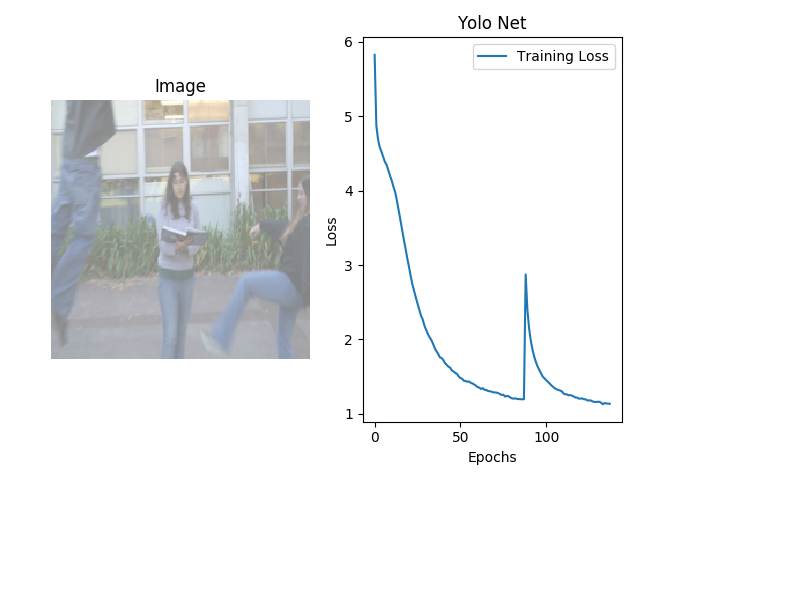

Start/Continue training from epoch 138


/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 

In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F
import torchvision as tv
from PIL import Image
import nntools as nt
from scipy.misc import imread,imresize
import cv2
import matplotlib.pyplot as plt
from dataloader import VOCDataset, myimshow
import model
import glob
class statsmanager(nt.StatsManager):
    def __init__self():
        super(statsmanager,self).__init__()

    def init(self):
        super(statsmanager,self).init()
        self.m_ap=0

    def accumulate(self,loss,x,y,d):
        #Do m_ap calculations
        super(statsmanager,self).accumulate(loss,x,y,d)
    

    def summarize(self):
        loss=super(statsmanager,self).summarize()
        return {'loss':loss}

def plot(self,fig,ax1, ax2 ,im):
    ax1.set_title('Image')
    x,y=train_set[0]
    myimshow(x,ax=ax1)
    ax2.set_title('Yolo Net')
    ax2.plot([exp1.history[k]['loss']for k in range(exp1.epoch)],label='Training Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='best')
    plt.tight_layout()
    fig.canvas.draw()

lr=1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
vgg = model.Yolo(64)
vgg.to(device)       
adam=torch.optim.Adam(vgg.parameters(),lr=lr)
stats_manager=statsmanager()
train_set=VOCDataset('/datasets/ee285f-public/PascalVOC2012/')
valid_set=VOCDataset('/datasets/ee285f-public/PascalVOC2012/', mode="val")
test_set=VOCDataset('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2012', mode="test")
x,y=train_set[1]
print(x.shape)
print(y.shape)

exp1=nt.Experiment(vgg,train_set,valid_set,adam,stats_manager,batch_size=64,output_dir="newloss",perform_validation_during_training=False)
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
exp1.load()
exp1.run(num_epochs=150,plot=lambda exp:plot(exp,fig=fig,ax1=ax1, ax2=ax2 ,im=x))



In [2]:
exp1.history

[{'loss': 5.827250557149795},
 {'loss': 4.873539705327488},
 {'loss': 4.687178526332672},
 {'loss': 4.584307154232168},
 {'loss': 4.522909910283624},
 {'loss': 4.452230304320229},
 {'loss': 4.385331893349714},
 {'loss': 4.346509879923122},
 {'loss': 4.273633837062407},
 {'loss': 4.1991103396696206},
 {'loss': 4.132958728361895},
 {'loss': 4.049371470742047},
 {'loss': 3.978274149053237},
 {'loss': 3.863278058760944},
 {'loss': 3.7396086205773176},
 {'loss': 3.6085752701376848},
 {'loss': 3.474665641784668},
 {'loss': 3.343127579612528},
 {'loss': 3.2242481695776957},
 {'loss': 3.093342855014903},
 {'loss': 2.978907673116674},
 {'loss': 2.8537852802378607},
 {'loss': 2.741390197034826},
 {'loss': 2.6501204655132193},
 {'loss': 2.564078560487472},
 {'loss': 2.48504959453236},
 {'loss': 2.401692403191551},
 {'loss': 2.3209891574268036},
 {'loss': 2.269641383446474},
 {'loss': 2.186223530514355},
 {'loss': 2.1288024072341103},
 {'loss': 2.073935872730724},
 {'loss': 2.0289967136587053},
 {

In [3]:
import os
import numpy as np
import torch
from torch import nn
import torch.utils.data as td
import torchvision as tv
import xml.etree.ElementTree as ET
from PIL import Image
from matplotlib import pyplot as plt
from scipy.misc import imread,imresize
import cv2

def decoder(pred):

    pred = pred.data
    pred = pred.squeeze(0) #7x7x30
    contain1 = pred[:,:,4].unsqueeze(2)
    contain2 = pred[:,:,9].unsqueeze(2)
    contain = torch.cat((contain1,contain2),2)
    mask1 = contain > 0.1 
    mask2 = (contain==contain.max())
    mask = (mask1+mask2).gt(0)
    boxes=[]
    cls_indexs=[]
    probs=[]
    for i in range(7):
        for j in range(7):
            for b in range(2):
                if mask[i][j][b]==1:
                    box = pred[i,j,b*5:b*5+4]
                    xc=pred[i,j,b*5]    
                    w=pred[i,j,b*5+2]
                    yc=pred[i,j,b*5+1]
                    h=pred[i,j,b*5+3]
                    x_new = torch.FloatTensor([i])*(1./7)
                    y_new=torch.FloatTensor([j])*(1./7)
                    xc=xc*(1./7)+x_new
                    yc=yc*(1./7)+y_new
                    x1=(xc-(w/2))
                    x2=(xc+(w/2))
                    y1=(yc-(h/2))
                    y2=(yc+(h/2))
                    bbox=torch.FloatTensor(box.size())
                    bbox[0]=x1
                    bbox[1]=y1
                    bbox[2]=x2
                    bbox[3]=y2
                    contain_prob=torch.FloatTensor([pred[i,j,b*5+4]])
                    max_prob,cls_index = torch.max(pred[i,j,10:],0)
                    if float((contain_prob*max_prob)[0]) > 0.1:
                        boxes.append(bbox.view(1,4))
                        cls_indexs.append(cls_index)
                        probs.append(contain_prob*max_prob)
    print(cls_indexs)
    if len(boxes)==0 or len(cls_indexs)==0:
        boxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        cls_indexs = torch.zeros(1)
    else:
        boxes = torch.cat(boxes,0) #(n,4)
        probs = torch.cat(probs,0) #(n,)
        cls_indexs = torch.stack(cls_indexs,0) #(n,)
    return boxes,probs,cls_indexs

In [4]:
def convert(img_path,lbl_path):
    lbl_tree = ET.parse(lbl_path)
    objs = []
    bbox=[]
    bboxes=[] 
    label=[]
    labels=[]
    
    voc_dict = {
                        'person':1, 'bird':2, 'cat':3, 'cow':4, 'dog':5, 
                        'horse':6, 'sheep':7, 'aeroplane':8, 'bicycle':9,
                        'boat':10, 'bus':11, 'car':12, 'motorbike':13, 'train':14, 
                        'bottle':15, 'chair':16, 'diningtable':17, 
                        'pottedplant':18, 'sofa':19, 'tvmonitor':20
                        }
    for obj in lbl_tree.iter(tag='object'):
        name = obj.find('name').text
        for box in obj.iter(tag='bndbox'):
            if name=='person':
                xmax = box.find('xmax').text
                xmin = box.find('xmin').text
                ymax = box.find('ymax').text
                ymin = box.find('ymin').text
                break
            xmax = box.find('xmax').text
            xmin = box.find('xmin').text
            ymax = box.find('ymax').text
            ymin = box.find('ymin').text
        attr = (voc_dict[name], float((float(xmin)+float(xmax))/2),float((float(ymin)+float(ymax))/2), float(float(xmax)-float(xmin)), float(float(ymax)-float(ymin)), 1)
        attr1=(xmax,xmin,ymax,ymin)
        objs.append(attr)
        bbox.append(attr1)
        
        
        #label.append(self.voc_dict[name])
        #bboxes.append(torch.Tensor(bbox))
        #labels.append(torch.IntTensor(label))
        

    objs = torch.Tensor(objs)
    
        # Open and normalize the image
    img = imread(img_path)
    h,w,_=img.shape
    img=imresize(img,(224,224))
    transform = tv.transforms.Compose([tv.transforms.ToTensor()])
    x = transform(img)
        
    target = torch.zeros((7,7,30))
    cls=torch.zeros((len(objs),20))
    x_list=torch.Tensor((len(objs)))
    y_list=torch.Tensor((len(objs)))
    w_list=torch.Tensor((len(objs)))
    h_list=torch.Tensor((len(objs)))
    x_index=torch.Tensor((len(objs)))
    y_index=torch.Tensor((len(objs)))
    x_new=torch.Tensor((len(objs)))
    y_new=torch.Tensor((len(objs)))
    del_x=torch.Tensor((len(objs)))
    del_y=torch.Tensor((len(objs)))
    for i in range(len(objs)):
        x_list[i]=objs[i][1]/w
        y_list[i]=objs[i][2]/h
        w_list[i]=objs[i][3]/w
            #w_list[i]=torch.sqrt(w_list[i])
        h_list[i]=objs[i][4]/h
            #h_list[i]=torch.sqrt(h_list[i])
        x_index[i]=(x_list[i]/(1./7)).ceil()-1
        y_index[i]=(y_list[i]/(1./7)).ceil()-1
        x_new[i]=x_index[i]*(1./7)
        y_new[i]=y_index[i]*(1./7)
        del_x[i]=(x_list[i]-x_new[i])/(1./7)
        del_y[i]=(y_list[i]-y_new[i])/(1./7)
    c=torch.ones(len(objs))
    bb_block=torch.cat((del_x.view(-1,1),del_y.view(-1,1),w_list.view(-1,1),h_list.view(-1,1),c.view(-1,1)),dim=1)
    bb_block=bb_block.repeat(1,2)

    for i in range(len(objs)):
        cls[i,int(objs[i][0])-1]=1
    final_bb=torch.cat((bb_block,cls),dim=1)

    for i in range(len(objs)):
        target[int(x_index[i]),int(y_index[i])]=final_bb[i].clone()
        
    return x,target


In [5]:
def nms(bboxes,scores,threshold=0.5):
    '''
    bboxes(tensor) [N,4]
    scores(tensor) [N,]
    '''
    x1 = bboxes[:,0]
    y1 = bboxes[:,1]
    x2 = bboxes[:,2]
    y2 = bboxes[:,3]
    areas = (x2-x1) * (y2-y1)
    _,order = scores.sort(0,descending=True)
    keep = []
    order1=order.numpy()
    while order1.size > 0:

        if order1.size == 1:
            i = order1
            keep.append(i)
            break
        i = order1[0]
        keep.append(i)
        xx1 = x1[order[1:]].clamp(min=x1[i].item())
        yy1 = y1[order[1:]].clamp(min=y1[i].item())
        xx2 = x2[order[1:]].clamp(max=x2[i].item())
        yy2 = y2[order[1:]].clamp(max=y2[i].item())

        w = (xx2-xx1).clamp(min=0)
        h = (yy2-yy1).clamp(min=0)
        inter = w*h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        ids = (ovr<=threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids+1]
        order1=order.numpy()
    return torch.LongTensor(keep)

In [5]:
def gt(img_path,lbl_path):
    #image_names=os.listdir(img_path)
    #image_names=[image.rstrip('.jpg') for image in image_names]
    
    
    lbl_tree = ET.parse(lbl_path)
    objs = []
    bbox=[]
    bboxes=[] 
    label=[]
    labels=[]
    
    voc_dict = {
                        'person':1, 'bird':2, 'cat':3, 'cow':4, 'dog':5, 
                        'horse':6, 'sheep':7, 'aeroplane':8, 'bicycle':9,
                        'boat':10, 'bus':11, 'car':12, 'motorbike':13, 'train':14, 
                        'bottle':15, 'chair':16, 'diningtable':17, 
                        'pottedplant':18, 'sofa':19, 'tvmonitor':20
                        }
    
    img = imread(img_path)
    h,w,_=img.shape
    for obj in lbl_tree.iter(tag='object'):
        name = obj.find('name').text
        for box in obj.iter(tag='bndbox'):
            if name=='person':
                xmax = box.find('xmax').text
                xmin = box.find('xmin').text
                ymax = box.find('ymax').text
                ymin = box.find('ymin').text
                break
            xmax = box.find('xmax').text
            xmin = box.find('xmin').text
            ymax = box.find('ymax').text
            ymin = box.find('ymin').text
        attr = (voc_dict[name], float((float(xmin)+float(xmax))/2),float((float(ymin)+float(ymax))/2), float(float(xmax)-float(xmin)), float(float(ymax)-float(ymin)), 1)
        attr1=float(xmin)/w,float(ymin)/h,float(xmax)/w,float(ymax)/h
        objs.append(attr)
        bbox.append(attr1)
    box1=torch.Tensor(len(bbox),4)
    for i in range(len(bbox)):
        box1[i][0]=bbox[i][0]
        box1[i][1]=bbox[i][1]
        box1[i][2]=bbox[i][2]
        box1[i][3]=bbox[i][3]
    #bbox=torch.Tensor(bbox)
    return box1

In [10]:
img = imread('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/JPEGImages/000006.jpg')
h,w,_=img.shape

a_gt=gt('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/JPEGImages/000006.jpg','/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/Annotations/000006.xml')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [12]:
def compute_iou(box1, box2):
    """
        cited from: https://github.com/xiongzihua/pytorch-YOLO-v1/blob/master/yoloLoss.py
    """
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
    
    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
 
    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)
    
    iou = inter_area / (b1_area + b2_area - inter_area)
    

    return iou   
    

In [11]:
for i in range(len(a_gt)):
    cv2.rectangle(img,(a_gt[i][0]*w,a_gt[i][3]*h),(a_gt[i][2]*w,a_gt[i][1]*h),[255,0,255],2)
plt.imshow(img)

In [13]:
for a1,a2,a3,a4 in a:
    cv2.rectangle(img,(a1*w,a4*h),(a3*w,a2*h),[255,255,0],2)
plt.imshow(img)

In [4]:
voc_dict1 = {0:'person', 1:'bird', 2:'cat', 3:'cow', 4:'dog',5:'horse', 6:'sheep', 7:'aeroplane', 8:'bicycle',9:'boat', 10:'bus', 11:'car', 12:'motorbike', 13:'train', 14:'bottle', 15:'chair', 16:'diningtable', 17:'pottedplant', 18:'sofa', 19:'tvmonitor'}
path='/datasets/home/88/288/mkulkarn/mAP/input/detection-results/'
img_path='/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2012/JPEGImages/'
for i in range(len(test_set)):
    x,y,z=test_set[i]
    x=x.view(1,3,224,224)
    x=x.to('cuda')
    op=vgg(x)
    op=op.view(7,7,30)
    a,b,c=decoder(op)
    img_path1=os.path.join(img_path,z+'.jpg')
    img = imread(img_path1)
    h,w,_=img.shape
    #keep=nms(a,b)
    #a=a[keep]
    #b=b[keep]
    #c=c[keep]
    if a.shape[1]==1:
        a=a.view(1,4)
        b=b.view(1)
        c=c.view(1)
    a=a.detach().numpy()
    b=b.detach().numpy()
    c=c.to('cpu')
    c=c.detach().numpy()
    file_path=os.path.join(path,z+'.txt')
    f=open(file_path,'w')
    for j in range(len(a)):
        f.write(voc_dict1[c[j].item()]+' '+str(b[j].item())+' '+str(int(a[j][0].item()*w))+' '+str(int(a[j][1].item()*h))+' '+str(int(a[j][2].item()*w))+' '+str(int(a[j][3].item()*h)))
        f.write('\n')

    f.close()
    

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(16, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


[tensor(0, device='cuda:0'), tensor(17, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]


[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(7, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(14, device='cuda:

[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), ten

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(18, device='cuda:0'), tensor(18, device='cuda:0'), tensor(13, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), ten

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(18, device='cuda:0'

[tensor(2, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(10, device='cuda:0'), tensor(10, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='c

[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(7, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0')]
[te

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[]
[tensor(4, device='cuda:0'), tensor(12, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(16, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), te

[tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(7, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(15, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(11, device='cuda:0'), tensor(4, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]


[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(5, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]


[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(16, device='cuda:0'), tensor(14, device='cuda:0'), tensor(19, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda

[tensor(0, device='cuda:0'), tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

[]
[tensor(11, device='cuda:0'), tensor(8, device='cuda:0'), tensor(11, device='cuda:0'), tensor(15, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(6, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cud

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(7, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(2, device='cuda:0'), tensor(18, device='cuda:0')]


[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[]
[]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(16, device='c

[tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(2, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tens

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(14, device='cuda:0')]
[tensor(2, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), 

[tensor(5, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(8, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]

[]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(

[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(12, device='cuda:0'), tensor(12, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(11, device='cuda:0'), tensor(15, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(7, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor

[tensor(0, device='cuda:0'), tensor(17, device='cuda:0'), tensor(10, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(18, device='cuda:0'), tensor(19, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(13, device='cuda:0'), tensor(19, device='cuda:0'), tensor(13, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(16, device='cuda:0'), tensor(16, device='c

[tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(1, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0

[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(5, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]


[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(18, de

[]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(19, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, devic

[]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(2, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(14, device='cuda:0'), tensor(15, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(17, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(10, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, dev

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(11, device='cuda:0'), tensor(8, device='cuda:0'), tensor(19, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), ten

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(1, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), t

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(8, device=

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tenso

[tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0')]
[tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(15, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'

[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(2, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(16, device='cuda

[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'

[tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(18, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(16, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(18, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(10, device='cuda:0')]
[tensor(15, device='cu

[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(14, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0'), tensor(9, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0

[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(10, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(18, device='cuda:0')]
[tensor(4, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0')]
[

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), tensor(2, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(12, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(10, device='cuda:0'), tensor(10, device='cuda:0'), tensor(0, device='cuda:0'), tensor(12, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), 

[]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(18, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device=

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tens

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), t

[tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tenso

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(7, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(11, device='cuda:0'), tensor(10, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(0, device='cud

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(1, device='cuda:0')

[tensor(19, device='cuda:0'), tensor(5, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

[tensor(19, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(6, device='cuda:0'), tensor(6, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(13, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cu

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda

[tensor(7, device='cuda:0')]
[]
[tensor(1, device='cuda:0'), tensor(15, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(7, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[

[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(18, device='cuda:0'), tensor(18, device

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[t

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(2, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(15, device='cuda:0'), tensor(19, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(15, device=

[tensor(1, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(15, device='cuda:0'), tensor(14, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(1, device='cud

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(12, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(5, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(14, device='cuda:0'), tensor(19, device='cuda:0'), tensor(9, device='cuda:0'), tensor(17, device='cud

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0'), tensor(18, device='cuda:0'), tensor(1, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(11, device='cuda:0'), tensor(15, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(19, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(18, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(17, device='cuda:0'), tensor(8, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0')]
[]
[tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
[]
[tensor(19, device='cuda:0'), tensor(16, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(9, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(6, device='cuda:0'

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(10, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(7, device='cuda:0'), tensor(9, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(19, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[]
[tensor(5, device='cuda:0')]
[tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(10, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0'

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(8, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(1, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(12, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(19, device='cuda:0'), tensor(15, device='cuda:0')]
[t

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(9, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0

[tensor(10, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(19, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0

[tensor(11, device='cuda:0')]
[tensor(5, device='cuda:0')]
[]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(15, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'

[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(14, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(4, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device

[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[]
[tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(12, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(1, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0

[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(12, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(0, device='cuda:0')]
[

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]


[]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(0, device='cuda:0'), 

[tensor(19, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(18, device='cuda:0'), tensor(14, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), te

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(4, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(3, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(14, device='cuda:0')

[]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(7, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(1, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(5, device='cuda:0'), tensor(13, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cu

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(2, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(17, device='cuda:0'), tensor(19, device='cuda:0'), tensor(18, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(9, de

[tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(16, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(5, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor

[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[]

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), te

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(6, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(8, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(14, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(17, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(17, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(10, device='cuda:0'), tensor(0, device

[]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(18, device='cud

[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(3, device='cuda:0'), tensor(5, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(16, device='cuda:0'), tensor(5, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[ten

[tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(12, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(18, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(7, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[]
[]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, dev

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(1, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0')]
[]
[tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:

[tensor(11, device='cuda:0')]
[]
[tensor(1, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(4, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda

[]
[]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(7, device='cuda:0'), tensor(11, device='cuda

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(9, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(8, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(16, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(16, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(17, device='cuda:0'), tensor(7, device='cuda:0'), 

[]
[tensor(13, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cud

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(10, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[t

[tensor(3, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(19, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(16, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(18, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tenso

[tensor(14, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(3, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(2, device='cuda:0')]
[]
[tensor(15, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), 

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'),

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(2, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(14, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tens

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(15, device='cuda:0'), tensor(18, device='cuda:0'), tensor(14, device='cuda:0'), tensor(4, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='c

[tensor(7, device='cuda:0')]
[tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(16, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0'), tensor(7, device='cuda:0'), tensor(1, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(1, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'),

[]
[tensor(7, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[]
[tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(16, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(2, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(8, device='cuda:0'), tensor(19, device='cuda:0'), tensor(15, device='cuda:0'), tensor(16, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cu

[tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(7, device='cuda:0')]
[]
[tensor(19, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device

[tensor(4, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), ten

[tensor(16, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(10, device='cuda:0'), tensor(10, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cud

[tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

[tensor(0, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(15, device='cuda:0'), tensor(7, device='cuda:0'), tensor(8, device='cuda:0'), tensor(8, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda

[tensor(0, device='cuda:0'), tensor(12, device='cuda:0'), tensor(12, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[]
[tensor(19, device='cuda:0')]
[tensor(6, device='cuda:0'), tensor(6, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(16, device='cuda:0'), tensor(9, device='cuda:0'), tensor(17, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(4, devic

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(2, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

[tensor(6, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(17, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cud

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='c

[tensor(9, device='cuda:0'), tensor(10, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(10, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(12, device='cuda:0'), tensor(12, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda

[tensor(15, device='cuda:0'), tensor(19, device='cuda:0'), tensor(16, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(10, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(3, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'),

[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(5, device='cuda:0'), tensor(19, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(17, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

[tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0'), tensor(1, device='cuda:0'), tensor(8, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

[tensor(15, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(1, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(9, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(17, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[]
[]
[tensor(4, device='cuda:0')]
[tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tenso

[]
[tensor(1, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[ten

[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(17, device='cuda:0'), tensor(18, device='cuda:0'), tensor(19, device='cuda:0'), tensor(15, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(10, device='cuda:0')]
[tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(15, device='cud

[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[]
[]
[tensor(14, device='cu

[tensor(7, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tens

[tensor(12, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(10, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(12, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='c

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(9, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

[tensor(1, device='cuda:0'), tensor(3, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(6, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(9, device='cuda:0')]
[]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cu

[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(12, device='cuda:0')]
[]
[tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(13, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(7, de

[]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(6, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cu

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(17, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cu

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(14, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tens

[tensor(19, device='cuda:0'), tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cud

[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(7, device='cuda:0')]
[]
[tensor(14, devic

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(10, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cu

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(1, device='cuda:0'), tensor(7, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[]
[

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(17, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(2, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(16, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0

[tensor(0, device='cuda:0')]
[]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(7, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(11, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(15, device

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(19, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(19, device='cuda:0'), tensor(9, device='cuda:0'), tensor(17, device='cuda:0')]
[tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), te

[tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(19, device='cuda:0'), tensor(18, device='cuda:0'), tensor(18, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(15, device='cuda:0'), tensor(15, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tens

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(9, device='cuda:0')]
[tensor(15, device='

[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[]
[tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(2, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(7, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0'), tensor(19, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(19, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(13, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]


[tensor(5, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(8, device='cuda:0'), tensor(8, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(8, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(18, device='cuda:0'), tensor(15, device='cuda:0'), tensor(13, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cu

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(18, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, d

[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(18, device='cuda:0'), tensor(18, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(11, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0,

[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(1, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(14, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(5, device='cuda:0'), tensor(5, device='cuda:0'

[tensor(15, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(17, device='cuda:0'), tensor(15, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0'), tensor(14, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
[tensor(1, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(18, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(19, device='cuda:0')]
[tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='c

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(14, device='cuda:0')]
[tensor(4, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(8, device='cuda:0')]


[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(19, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(12, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
[tensor(7, device='cuda:0')]
[]
[]
[tensor(0, device='cu

In [12]:
x1,y1=convert('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/JPEGImages/000006.jpg','/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/Annotations/000006.xml')

x1=x1.view(1,3,224,224)
x1=x1.to('cuda')
op=vgg(x1)
op=op.view(7,7,30)
a,b,c=decoder(op)
#keep=nms(a,b)
#a=a[keep]
#b=b[keep]
#c=c[keep]
#print(a,b,c)

[tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


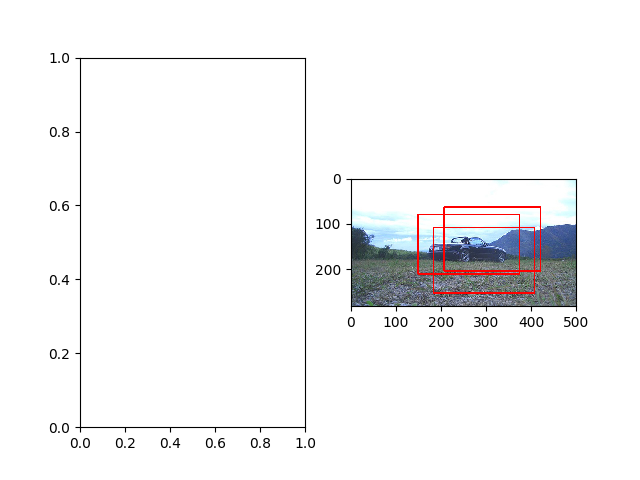

In [10]:
fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)